### This notebook's purpose is to get the CALCE data in a workable format (in a dataframe, cleaned, battery type labeled etc.)

### Goals: (Add to this)
1. Get files from CALCE website into dataframe(s)
2. Add label for every cycle which battery this data came from 
3. Find/Remove empty cells  (delete the whole row or should we do interpolation?) (Might not even have empty cells)


All CS2 cells underwent the same charging profile which was a standard constant current/constant voltage protocol with a constant current rate of 0.5C until the voltage reached 4.2V and then 4.2V was sustained until the charging current dropped to below 0.05A. Unless specified, the discharge cut off voltage for these batteries was 2.7V. All the CS2 cells were randomly numbered and named accordingly. Name 'CS2_n' was given for the nth numbered CS2 cell. 

#### Imports:

In [1]:
import scipy.io
import scipy.signal
import os 
import pandas as pd
import zipfile
import requests
import xlrd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import statistics as stats
from math import isclose
%matplotlib inline

#### Notes:
To import .mat files into python:  
import scipy.io   
mat = scipy.io.loadmat('file.mat')  

To unzip files: look at SEDS HW2 (not sure if we will use this)


#### CS2 data (in excel format*)  
Look at CS2 data first. From the website, CS2_'n' was given to the nth numbered CS2 cell (identifies unique cells from eachother). Each cell was cycled multiple times. Excel files are named using the testing dates.  **Were the same cells cycled on different dates or was the continuous cycling data split into multiple excel files?**   

*CS2_8 and CS2_21 are in .txt format because they were cycled using a different system.

Starting with CS2_33, in excel file format

In [2]:
data1 = pd.read_excel("data/CS2_33/CS2_33_10_04_10.xlsx", sheet_name= "Channel_1-006")
#it looks like all of these have the sheet name channel_1-006, not just this specific excel file? 
#would be nice to create a function to iterate over all the files in a given file and import them, store them in variable. 

In [3]:
data1['Cycle_Index'].max()
#this gives the number of cycles they ran

23

In [4]:
#we will need to clean the data so that dq/dv does not come back with weird data, ie we need to make sure the dq/dv isn't being 
# calculated between identical voltage values (because then dv = 0)
# (dq/dt)/(dv/dt)= dq/dv 
# (dq/dt) = current 


# calculate dv, find values close to 0, delete those rows, reindex, calculate dv again, 

New Column- To calculate dq/dv do discharge/charge capacity/ dv. calculate dv first. Ask robert whether to use discharge or charge capacity to calculate this. or do both and compare. Maybe ask user which capacity to use between discharge and charge - depends on system (i.e. Maccor) , which anode or cathode they are looking at etc. 

In [5]:
data1['dV'] = None 

In [6]:
data1.loc[2, ('Voltage(V)')]

3.4519877433776855

In [7]:
range(len(data1))

range(0, 10759)

In [8]:
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]


In [9]:
data1['dQ/dV-dis'] = data1['Discharge_Capacity(Ah)']/data1['dV']

In [10]:
#data1 = data1.replace([np.inf, -np.inf], np.nan).dropna(subset=['dQ/dV-dis'])

In [11]:
#data1 = data1.reset_index(drop = True)

In [12]:
data1['dQ/dV-dis'].mean()

inf

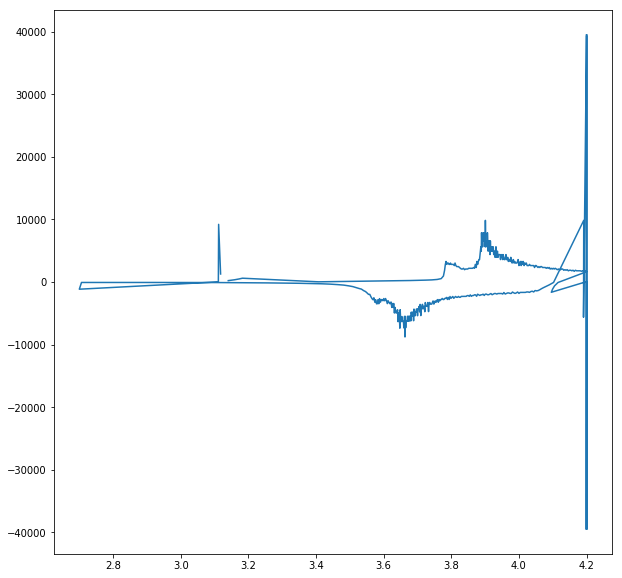

In [14]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['dQ/dV-dis'])

In [15]:
for i in range(1,len(data1)):
    if isclose(data1.loc[i, ('dV')], 0, abs_tol = 10**-3):
        data1 = data1.drop(index = i)
#drop rows if dv is about 0, this will clean up the data points around V = 4.2V (since they are holding it at 4.2V for a while)
#have to recalculate the dv after this I think 

In [16]:
len(data1)

9758

In [17]:
data1 = data1.reset_index(drop = True)

In [18]:
#recalculating dv after dropping rows
for i in range(1,len(data1)): 
    data1.loc[i, ('dV')] = data1.loc[i, ('Voltage(V)')] - data1.loc[i-1, ('Voltage(V)')]


In [19]:
#recalculate dq/dv  
data1['dQ/dV-dis'] = data1['Discharge_Capacity(Ah)']/data1['dV']

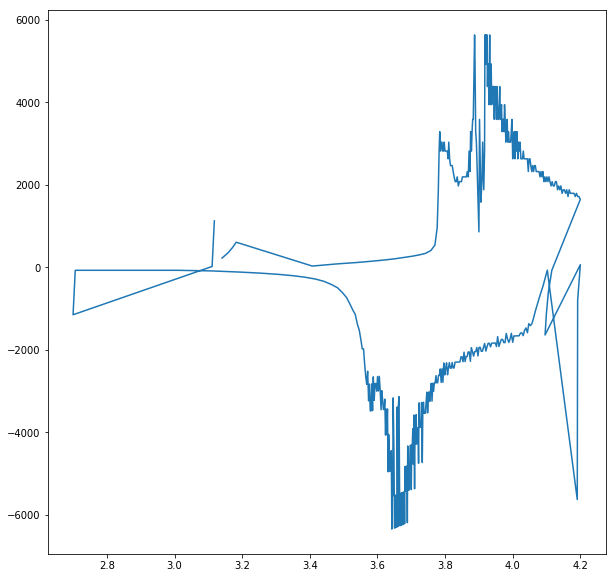

In [20]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['dQ/dV-dis'])

In [21]:
data1['dQ/dV-char'] = data1['Charge_Capacity(Ah)']/data1['dV']

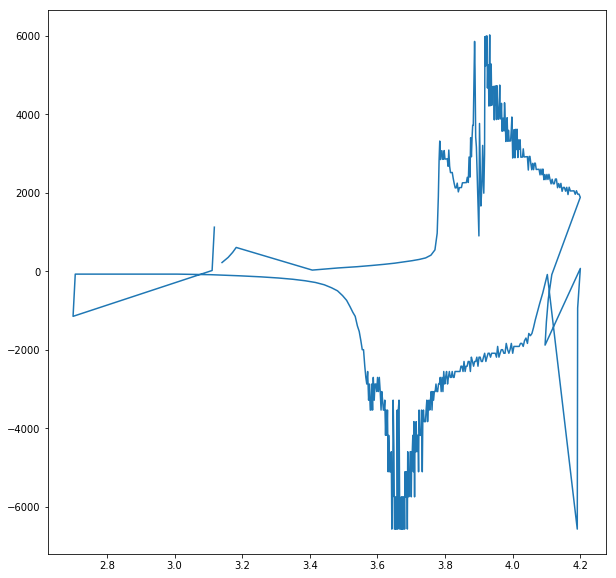

In [22]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['dQ/dV-char'])
# This is to see if using the charging capacity looks any different than using the discharging capacity. Look very similar. 

In [24]:
data1['dQ/dV-dis'].max()

41913.563841084666

In [25]:
data1['dQ/dV-dis'].min()

-20549.10282026607

In [26]:
data1['dQ/dV-char'].max()

44084.29889454303

In [27]:
data1['dQ/dV-char'].min()

-20774.622263376248

In [29]:
data1.shape

(9758, 20)

Drop Rows With N/A in dq/dv-discharge cap row. First replace inf values for N/a values so can use dropna

In [32]:
#will need to drope na row, there should only be one. 
data1.dropna(subset=['dQ/dV-dis'], inplace= True)

In [33]:
data1.shape

(9757, 20)

In [36]:
data1 = data1.reset_index(drop = True)

In [37]:
#recalculate dq/dv after dropping n/a row
data1['dQ/dV-dis'] = data1['Discharge_Capacity(Ah)']/data1['dV']

Reindex and calculate dV again 

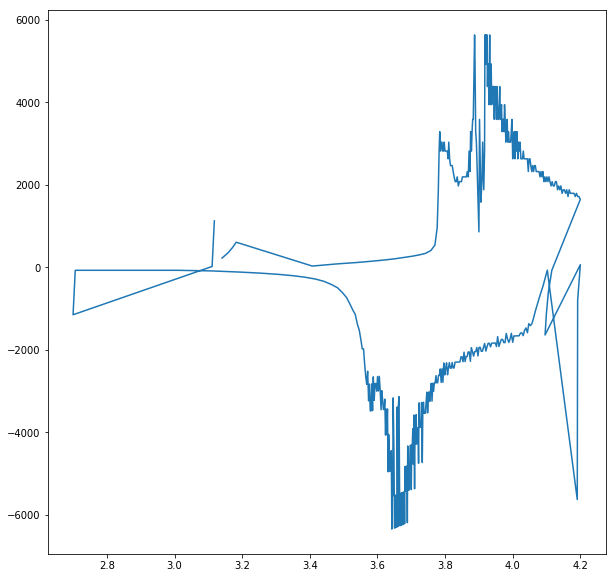

In [38]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 7:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['dQ/dV-dis'])
 

### Filter Sav Golay

In [39]:
data1['dV'].describe()

count     9757.000000
unique     756.000000
top          0.002268
freq       306.000000
Name: dV, dtype: float64

In [42]:
unfilt = pd.concat([data1['dQ/dV-dis']])

In [43]:
unfiltar = unfilt.values
#converts into an array 

In [49]:
data1['filtered dq/dv'] = scipy.signal.savgol_filter(unfiltar, 21, 3)

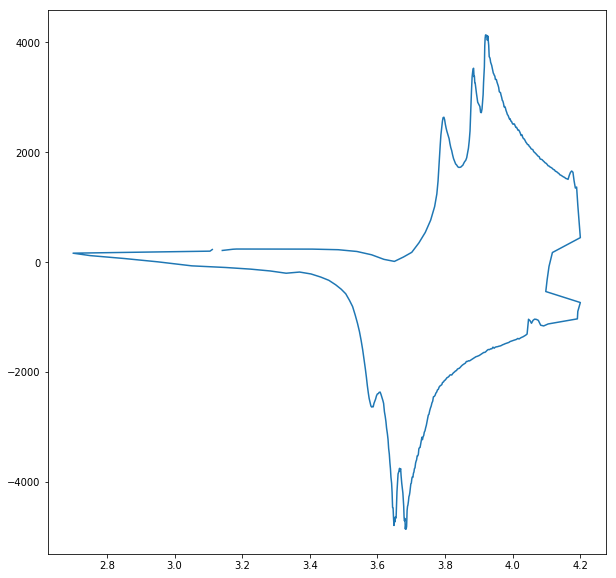

In [50]:
df1 = pd.DataFrame() 
for i in range(1,len(data1)):
    if data1.loc[i, ('Cycle_Index')] == 6:
        df1 = df1.append(data1.loc[i])
        
fig = plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
myplot = plt.plot(df1['Voltage(V)'], df1['filtered dq/dv'])

### Separate by Cycle

In [ ]:
data1['Cycle_Index'].max()

In [ ]:
gb = data1.groupby(by = ['Cycle_Index'])

In [ ]:
print(gb)

In [ ]:
for i in range(1, data1['Cycle_Index'].max() + 1):
    print(i)
    